<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/lstm/CA_TimeSeries_LSTM_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab finds the possible 'New Cases' in some counties in California after PCA analysis 

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_CovidDataJan10.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Jan10.csv
 NY_alldatasets_Jan13.csv
 NY_CombinedData_Labeled_CDCGuideline_Jan15.csv
 NY_CovidDataJan10.csv
 NY_GoogleMobilityDataJan10.csv
 NY_MarylandData_Labeled_CDCGuideline_Jan15.csv
 NY_processedMarylandData_Jan11.csv
 NY_SocialDistancingDataJan10.csv
'Policy_Map_(Sized)_Full_Data_data.csv'
 TX_alldatasets_Jan11.csv
 TX_CombinedData_Labeled_CDCGuideline_Jan15.csv
 TX_CovidDataJan10.csv
 TX_GoogleMobilityDataJan10.csv
 TX_MarylandData_Labeled_CDCGuideline_Jan15.csv
 TX_processedMarylandData_Jan11.csv
 TX_processedMarylandData_Jan11.gsheet
 TX_SocialDistancingDataJan10.cs

In [30]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import median_absolute_error, mean_absolute_error


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


# Load combined data for CA

In [159]:
CA_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_alldatasets_Jan13.csv',low_memory=False)
CA_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,California,6001,0,Alameda County,1671329,0,3.6840,58,6.0000,9.0000,15.0000,1.0000,4.0000,0.0000
1,2020-03-02,California,6001,0,Alameda County,1671329,0,6.1820,98,4.0000,7.0000,7.0000,-1.0000,3.0000,0.0000
2,2020-03-03,California,6001,1,Alameda County,1671329,0,6.2710,100,5.0000,12.0000,41.0000,0.0000,1.0000,-1.0000
3,2020-03-04,California,6001,0,Alameda County,1671329,0,6.2090,99,1.0000,6.0000,23.0000,-3.0000,1.0000,0.0000
4,2020-03-05,California,6001,0,Alameda County,1671329,0,6.6540,106,1.0000,6.0000,12.0000,-5.0000,-1.0000,1.0000


In [160]:
X_cols_all = [ 'mask_rule_active','m50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline','Date','New cases']

X_cols_feature_selected = ['retail_and_recreation_percent_change_from_baseline', 'mask_rule_active', 
                           'workplaces_percent_change_from_baseline',  'parks_percent_change_from_baseline', 
                            'transit_stations_percent_change_from_baseline','Date','New cases']


In [161]:
LA_combined_data_all = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(300, 11)
(300, 7)


,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Date,New cases
4940,0,3.9960,60,4.0000,3.0000,-5.0000,-3.0000,1.0000,0.0000,2020-03-01,0
4941,0,6.5020,98,5.0000,5.0000,8.0000,1.0000,4.0000,-1.0000,2020-03-02,0
4942,0,6.5910,99,8.0000,7.0000,32.0000,2.0000,3.0000,-1.0000,2020-03-03,0
4943,0,6.5950,100,4.0000,6.0000,9.0000,-1.0000,2.0000,0.0000,2020-03-04,6
4944,0,7.0080,106,4.0000,7.0000,9.0000,0.0000,2.0000,0.0000,2020-03-05,4


In [165]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [163]:
len(LA_combined_data_featured.columns)

7

In [166]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,retail_and_recreation_percent_change_from_baseline,mask_rule_active,workplaces_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,Date,New cases
4940,4.0000,0,1.0000,-5.0000,-3.0000,1583020800.0000,0
4941,5.0000,0,4.0000,8.0000,1.0000,1583107200.0000,0
4942,8.0000,0,3.0000,32.0000,2.0000,1583193600.0000,0
4943,4.0000,0,2.0000,9.0000,-1.0000,1583280000.0000,6
4944,4.0000,0,2.0000,9.0000,0.0000,1583366400.0000,4


In [167]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

7


retail_and_recreation_percent_change_from_baseline    float64
mask_rule_active                                        int64
workplaces_percent_change_from_baseline               float64
parks_percent_change_from_baseline                    float64
transit_stations_percent_change_from_baseline         float64
Date                                                  float64
New cases                                               int64
dtype: object

## Preprocessing data for LSTM

In [168]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [169]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [170]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var9(t)  var10(t)  var11(t)
1     0.0000     0.5419     0.5405  ...   0.0000    0.0032    0.0000
2     0.0000     0.8841     0.8829  ...   0.0000    0.0065    0.0000
3     0.0000     0.8962     0.8919  ...   0.0303    0.0097    0.0181
4     0.0000     0.8968     0.9009  ...   0.0303    0.0129    0.0108
5     0.0000     0.9532     0.9550  ...   0.0303    0.0161    0.0072

[5 rows x 22 columns]


## Train Test Split

In [38]:
values.shape[0]

300

In [171]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

236
values shape  (299, 22)
(236, 1, 21) (236,) (63, 1, 21) (63,)


## Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.3920 - val_loss: 0.7307
Epoch 2/100
4/4 - 0s - loss: 0.3117 - val_loss: 0.6313
Epoch 3/100
4/4 - 0s - loss: 0.2519 - val_loss: 0.5344
Epoch 4/100
4/4 - 0s - loss: 0.2096 - val_loss: 0.4477
Epoch 5/100
4/4 - 0s - loss: 0.1905 - val_loss: 0.3838
Epoch 6/100
4/4 - 0s - loss: 0.1873 - val_loss: 0.3484
Epoch 7/100
4/4 - 0s - loss: 0.1882 - val_loss: 0.3363
Epoch 8/100
4/4 - 0s - loss: 0.1877 - val_loss: 0.3390
Epoch 9/100
4/4 - 0s - loss: 0.1859 - val_loss: 0.3507
Epoch 10/100
4/4 - 0s - loss: 0.1837 - val_loss: 0.3670
Epoch 11/100
4/4 - 0s - loss: 0.1824 - val_loss: 0.3828
Epoch 12/100
4/4 - 0s - loss: 0.1821 - val_loss: 0.3945
Epoch 13/100
4/4 - 0s - loss: 0.1820 - val_loss: 0.3992
Epoch 14/100
4/4 - 0s - loss: 0.1811 - val_loss: 0.3969
Epoch 15/100
4/4 - 0s - loss: 0.1795 - val_loss: 0.3898
Epoch 16/100
4/4 - 0s - loss: 0.1774 - val_loss: 0.3803
Epoch 17/100
4/4 - 0s - loss: 0.1756 - val_loss: 0.3721
Epoch 18/100
4/4 - 0s - loss: 0.1740 - val_loss: 0.3664
E

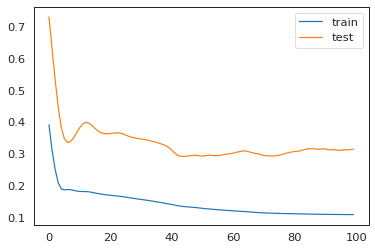

In [172]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [174]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(63, 21)
Test MSE: 0.117
Test RMSE: 0.342
median_absolute_error 0.33511466
mean_absolute_error 0.31553134


# Preprocessing feature selected data for training

In [43]:
len(LA_combined_data_featured_selected.columns)

7

In [175]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var5(t)  var6(t)  var7(t)
1     0.9512     0.0000     0.9655  ...   0.9863   0.0032   0.0000
2     0.9634     0.0000     1.0000  ...   1.0000   0.0065   0.0000
3     1.0000     0.0000     0.9885  ...   0.9589   0.0097   0.0181
4     0.9512     0.0000     0.9770  ...   0.9726   0.0129   0.0108
5     0.9512     0.0000     0.9770  ...   0.9452   0.0161   0.0072

[5 rows x 14 columns]


## Train Test split

In [176]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

236
values shape  (299, 14)
(236, 1, 13) (236,) (63, 1, 13) (63,)


## Training LSTM for feature selected data

In [179]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 2s - loss: 0.4527 - val_loss: 0.7792
Epoch 2/200
4/4 - 0s - loss: 0.3859 - val_loss: 0.6992
Epoch 3/200
4/4 - 0s - loss: 0.3228 - val_loss: 0.6199
Epoch 4/200
4/4 - 0s - loss: 0.2742 - val_loss: 0.5432
Epoch 5/200
4/4 - 0s - loss: 0.2350 - val_loss: 0.4695
Epoch 6/200
4/4 - 0s - loss: 0.2083 - val_loss: 0.4029
Epoch 7/200
4/4 - 0s - loss: 0.1919 - val_loss: 0.3505
Epoch 8/200
4/4 - 0s - loss: 0.1842 - val_loss: 0.3151
Epoch 9/200
4/4 - 0s - loss: 0.1817 - val_loss: 0.2964
Epoch 10/200
4/4 - 0s - loss: 0.1807 - val_loss: 0.2907
Epoch 11/200
4/4 - 0s - loss: 0.1798 - val_loss: 0.2937
Epoch 12/200
4/4 - 0s - loss: 0.1788 - val_loss: 0.3016
Epoch 13/200
4/4 - 0s - loss: 0.1781 - val_loss: 0.3114
Epoch 14/200
4/4 - 0s - loss: 0.1778 - val_loss: 0.3209
Epoch 15/200
4/4 - 0s - loss: 0.1778 - val_loss: 0.3293
Epoch 16/200
4/4 - 0s - loss: 0.1777 - val_loss: 0.3341
Epoch 17/200
4/4 - 0s - loss: 0.1775 - val_loss: 0.3359
Epoch 18/200
4/4 - 0s - loss: 0.1769 - val_loss: 0.3355
E

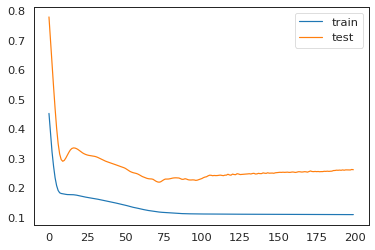

In [180]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Testing feature selected data

In [181]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(63, 13)
Test MSE: 0.084
Test RMSE: 0.290
median_absolute_error 0.27037543
mean_absolute_error 0.26209176


# Conclusion for all dataset after PCA

| data | MSE  |RMSE  |Median AE  |MAE|
|------|------|-----|------|-----|
|   without PCA  | 0.117| 0.342|0.335|0.315|
|   with PCA  | 0.085| 0.291|0.272|0.264|

# Load Maryland inertia

In [133]:
CA_maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_processedMarylandData_Jan11.csv',low_memory=False)
CA_maryland_sd_inertia.head(5)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.4100,26.1000,0.4000,38.0000,0.2000,2.2100,0,1666753,-21.7000,2020-01-01,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.1700,27.9000,0.4000,38.5000,0.5000,2.6600,0,1666753,-5.8000,2020-01-02,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
2,6001,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.2800,27.2000,0.4000,41.0000,0.5100,2.7800,0,1666753,-1.5000,2020-01-03,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
3,6001,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.0300,25.8000,0.3000,41.1000,0.2600,2.7600,0,1666753,-2.2000,2020-01-04,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
4,6001,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.7200,24.5000,0.4000,35.8000,0.2400,2.4800,0,1666753,-12.1000,2020-01-05,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,0.3000,0.0000


In [107]:
def fixDate(x, appendTwenty):
  arr = x.split('-')
  y = arr[0]
  d = arr[1]
  m = arr[2]

  if appendTwenty == True:
    return '20'+y+'-'+m+'-'+d
  else:
      return y+'-'+m+'-'+d

In [108]:
CA_maryland_sd_inertia['date'] = CA_maryland_sd_inertia['date'].apply(lambda x:fixDate(x,False))
CA_maryland_sd_inertia.head()

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.4100,26.1000,0.4000,38.0000,0.2000,2.2100,0,1666753,-21.7000,2020-01-01,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.1700,27.9000,0.4000,38.5000,0.5000,2.6600,0,1666753,-5.8000,2020-02-01,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
2,6001,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.2800,27.2000,0.4000,41.0000,0.5100,2.7800,0,1666753,-1.5000,2020-03-01,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
3,6001,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.0300,25.8000,0.3000,41.1000,0.2600,2.7600,0,1666753,-2.2000,2020-04-01,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
4,6001,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.7200,24.5000,0.4000,35.8000,0.2400,2.4800,0,1666753,-12.1000,2020-05-01,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,0.3000,0.0000


In [134]:
print(len(CA_maryland_sd_inertia.columns))
CA_maryland_sd_inertia.dtypes


47


countyFIPS                                  int64
County Name                                object
State                                      object
population                                  int64
CTFIPS                                      int64
CTNAME                                     object
STFIPS                                      int64
Social.distancing.index                     int64
X..staying.home                             int64
Trips.person                              float64
X..out.of.county.trips                    float64
X..out.of.state.trips                     float64
Miles.person                              float64
Work.trips.person                         float64
Non.work.trips.person                     float64
New.COVID.cases                             int64
Population                                  int64
X..change.in.consumption                  float64
date                                       object
Transit.mode.share                        float64


In [146]:
inertia_X_cols_all = ['Social.distancing.index', 'X..staying.home', 'Trips.person',
                  'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
                  'Work.trips.person', 'Non.work.trips.person','X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans','X..Hispanic.Americans',
        'X..Male', 'Population.density',
       'Employment.density', 
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
       'Unemployment.rate', 'X..working.from.home',
       'Cumulative.inflation.rate', 'date','New.COVID.cases']

inertia_X_cols_featured = [ 'X..staying.home',
                           'X..hot.spots.1000.people', 'X..change.in.consumption',
                            'X.days..decreasing.ILI.cases', 
                           'X..Male', 'Testing.capacity', 'X..Hispanic.Americans', 
                           'X.days..decreasing.COVID.cases', 'X.days..decreasing.COVID.cases', 
                           'X..African.Americans', 'Miles.person', 'Median.income',
                           'X..out.of.state.trips', 'Work.trips.person','date',
                           'Testing.capacity', 'Transit.mode.share','New.COVID.cases']


In [147]:
LA_inertia_data_all = CA_maryland_sd_inertia[CA_maryland_sd_inertia['CTNAME'] == 'Los Angeles County'][inertia_X_cols_all]
LA_inertia_data_featured = CA_maryland_sd_inertia[CA_maryland_sd_inertia['CTNAME'] == 'Los Angeles County'][inertia_X_cols_featured]
print(len(LA_inertia_data_all.columns))
LA_inertia_data_all.head()

35


,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,Hospital.beds.1000.people,ICUs.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,date,New.COVID.cases
6534,49,32,2.4200,12.1000,0.6000,31.4000,0.2100,2.2100,-20.1000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,2020-01-01,0
6535,22,21,3.1900,11.3000,0.5000,36.6000,0.5600,2.6200,-5.3000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,2020-01-02,0
6536,18,20,3.3200,11.2000,0.4000,37.9000,0.5600,2.7700,0.2000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,2020-01-03,0
6537,29,24,3.1000,11.6000,0.5000,36.0000,0.3000,2.7900,0.9000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,2020-01-04,0
6538,40,28,2.7500,11.3000,0.5000,33.1000,0.2500,2.5000,-9.6000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,0.3000,2020-01-05,0


In [132]:
#LA_inertia_data_all['date'] = LA_inertia_data_all['date'].apply(lambda x: parse(x))
#LA_inertia_data_featured['date'] = LA_inertia_data_featured['date'].apply(lambda x: parse(x))

# Preprocess Data for inertia datasets

In [143]:
def datetime_to_float(d):
    date_time_obj = datetime.datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [148]:
print(len(inertia_X_cols_all))
LA_inertia_data_all['date'] = LA_inertia_data_all['date'].apply(lambda x:datetime_to_float(x))

35


In [139]:
print(LA_inertia_data_all.shape)
LA_inertia_data_all.head()

(363, 37)


,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,date,New.COVID.cases
6534,49,32,2.4200,12.1000,0.6000,31.4000,0.2100,2.2100,-20.1000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,1577836800.0000,0
6535,22,21,3.1900,11.3000,0.5000,36.6000,0.5600,2.6200,-5.3000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,1577923200.0000,0
6536,18,20,3.3200,11.2000,0.4000,37.9000,0.5600,2.7700,0.2000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,1578009600.0000,0
6537,29,24,3.1000,11.6000,0.5000,36.0000,0.3000,2.7900,0.9000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,1578096000.0000,0
6538,40,28,2.7500,11.3000,0.5000,33.1000,0.2500,2.5000,-9.6000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,0.3000,1578182400.0000,0


In [149]:
values = LA_inertia_data_all.values
# integer encode direction
encoder = LabelEncoder()
values[:,34] = encoder.fit_transform(values[:,34])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var33(t)  var34(t)  var35(t)
1     0.5373     0.4286     0.3333  ...    0.0662    0.0028    0.0000
2     0.1343     0.1143     0.7407  ...    0.0662    0.0055    0.0000
3     0.0746     0.0857     0.8095  ...    0.0662    0.0083    0.0000
4     0.2388     0.2000     0.6931  ...    0.0662    0.0110    0.0000
5     0.4030     0.3143     0.5079  ...    0.0662    0.0138    0.0000

[5 rows x 70 columns]


## Train Test split

In [150]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

288
values shape  (362, 70)
(288, 1, 69) (288,) (74, 1, 69) (74,)


## Training LSTM for inertia data

Epoch 1/100
4/4 - 2s - loss: 0.2555 - val_loss: 0.4936
Epoch 2/100
4/4 - 0s - loss: 0.1933 - val_loss: 0.3699
Epoch 3/100
4/4 - 0s - loss: 0.1732 - val_loss: 0.2812
Epoch 4/100
4/4 - 0s - loss: 0.1699 - val_loss: 0.2311
Epoch 5/100
4/4 - 0s - loss: 0.1672 - val_loss: 0.2127
Epoch 6/100
4/4 - 0s - loss: 0.1597 - val_loss: 0.2136
Epoch 7/100
4/4 - 0s - loss: 0.1491 - val_loss: 0.2236
Epoch 8/100
4/4 - 0s - loss: 0.1384 - val_loss: 0.2321
Epoch 9/100
4/4 - 0s - loss: 0.1296 - val_loss: 0.2304
Epoch 10/100
4/4 - 0s - loss: 0.1257 - val_loss: 0.2087
Epoch 11/100
4/4 - 0s - loss: 0.1219 - val_loss: 0.1785
Epoch 12/100
4/4 - 0s - loss: 0.1182 - val_loss: 0.1548
Epoch 13/100
4/4 - 0s - loss: 0.1152 - val_loss: 0.1460
Epoch 14/100
4/4 - 0s - loss: 0.1125 - val_loss: 0.1504
Epoch 15/100
4/4 - 0s - loss: 0.1088 - val_loss: 0.1555
Epoch 16/100
4/4 - 0s - loss: 0.1069 - val_loss: 0.1556
Epoch 17/100
4/4 - 0s - loss: 0.1045 - val_loss: 0.1517
Epoch 18/100
4/4 - 0s - loss: 0.1028 - val_loss: 0.1502
E

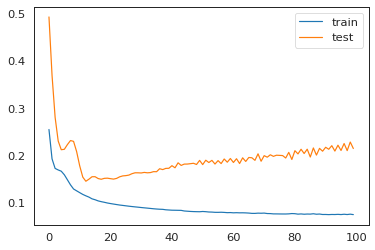

In [151]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Testing LSTM for inertia data

In [152]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(74, 69)
Test MSE: 0.058
Test RMSE: 0.240


In [153]:
from sklearn.metrics import median_absolute_error, mean_absolute_error
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

median_absolute_error 0.20667042
mean_absolute_error 0.21527839


# Preprocessing Data for PCA feature selected-inertia

In [154]:
print(len(inertia_X_cols_featured))
LA_inertia_data_featured['date'] = LA_inertia_data_featured['date'].apply(lambda x:datetime_to_float(x))

18


In [155]:
values = LA_inertia_data_featured.values
# integer encode direction
encoder = LabelEncoder()
values[:,17] = encoder.fit_transform(values[:,17])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var16(t)  var17(t)  var18(t)
1     0.4286     0.0000     0.3748  ...    0.0000    0.0000    0.0000
2     0.1143     0.0000     0.6304  ...    0.0000    0.0000    0.0000
3     0.0857     0.0000     0.7254  ...    0.0000    0.0000    0.0000
4     0.2000     0.0000     0.7375  ...    0.0000    0.0000    0.0000
5     0.3143     0.0000     0.5561  ...    0.0000    0.0000    0.0000

[5 rows x 36 columns]


## Train Test Split

In [156]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

288
values shape  (362, 36)
(288, 1, 35) (288,) (74, 1, 35) (74,)


## Training LSTM for PCA feature selected 

Epoch 1/100
4/4 - 2s - loss: 0.2993 - val_loss: 0.6583
Epoch 2/100
4/4 - 0s - loss: 0.2630 - val_loss: 0.5944
Epoch 3/100
4/4 - 0s - loss: 0.2394 - val_loss: 0.5372
Epoch 4/100
4/4 - 0s - loss: 0.2199 - val_loss: 0.4857
Epoch 5/100
4/4 - 0s - loss: 0.2076 - val_loss: 0.4436
Epoch 6/100
4/4 - 0s - loss: 0.1986 - val_loss: 0.4072
Epoch 7/100
4/4 - 0s - loss: 0.1933 - val_loss: 0.3779
Epoch 8/100
4/4 - 0s - loss: 0.1894 - val_loss: 0.3543
Epoch 9/100
4/4 - 0s - loss: 0.1859 - val_loss: 0.3361
Epoch 10/100
4/4 - 0s - loss: 0.1822 - val_loss: 0.3226
Epoch 11/100
4/4 - 0s - loss: 0.1780 - val_loss: 0.3124
Epoch 12/100
4/4 - 0s - loss: 0.1736 - val_loss: 0.3050
Epoch 13/100
4/4 - 0s - loss: 0.1690 - val_loss: 0.3000
Epoch 14/100
4/4 - 0s - loss: 0.1644 - val_loss: 0.2961
Epoch 15/100
4/4 - 0s - loss: 0.1597 - val_loss: 0.2918
Epoch 16/100
4/4 - 0s - loss: 0.1556 - val_loss: 0.2859
Epoch 17/100
4/4 - 0s - loss: 0.1523 - val_loss: 0.2779
Epoch 18/100
4/4 - 0s - loss: 0.1495 - val_loss: 0.2686
E

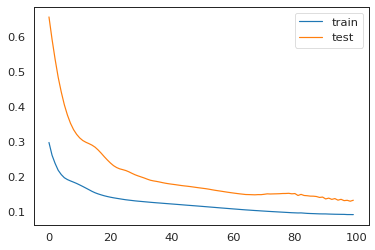

In [157]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Testing LSTM for PCA feature selected

In [158]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(74, 35)
Test MSE: 0.042
Test RMSE: 0.204
median_absolute_error 0.08787784
mean_absolute_error 0.134258


# Conclusion for inertia dataset after PCA

| data | MSE  |RMSE  |Median AE  |MAE|
|------|------|-----|------|-----|
|   without PCA  | 0.05| 0.24|0.206|0.215|
|   with PCA  | 0.04| 0.204|0.087|0.134|
